# Simon's Algorithm

# 1. Installation

In [2]:
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle

# The function simon_oracle (imported above) creates a Simon oracle for the bitstring b

We now implement Simon's algorithm for an example with 3 quibits and b = '110'

# 2. Circuit

In [3]:
b = '110'

n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit.h(range(n))    

# Apply barrier for visual separation
simon_circuit.barrier()1
simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to the input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()

<ipython-input-3-43e26ab50455>:12: DeprecationWarning: The QuantumCircuit.__iadd__() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  simon_circuit += simon_oracle(b)
C:\Users\hrith\anaconda3\lib\site-packages\qiskit\circuit\quantumcircuit.py:942: DeprecationWarning: The QuantumCircuit.extend() method is being deprecated. Use the compose() (potentially with the inplace=True argument) and tensor() methods which are more flexible w.r.t circuit register compatibility.
  return self.extend(rhs)


┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

# 3. Simulator Output

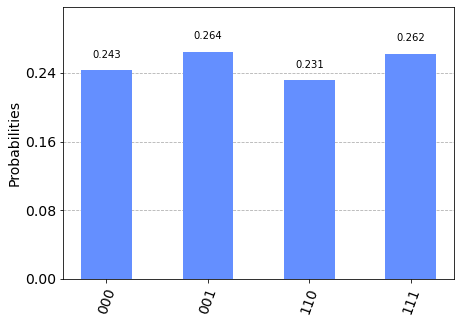

In [4]:
# use local simulator
aer_sim = Aer.get_backend('aer_simulator')
shots = 1024
qobj = assemble(simon_circuit, shots=shots)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

# 4. Verify result(Simulator)

In [5]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )

110.110 = 0 (mod 2)
110.000 = 0 (mod 2)
110.001 = 0 (mod 2)
110.111 = 0 (mod 2)


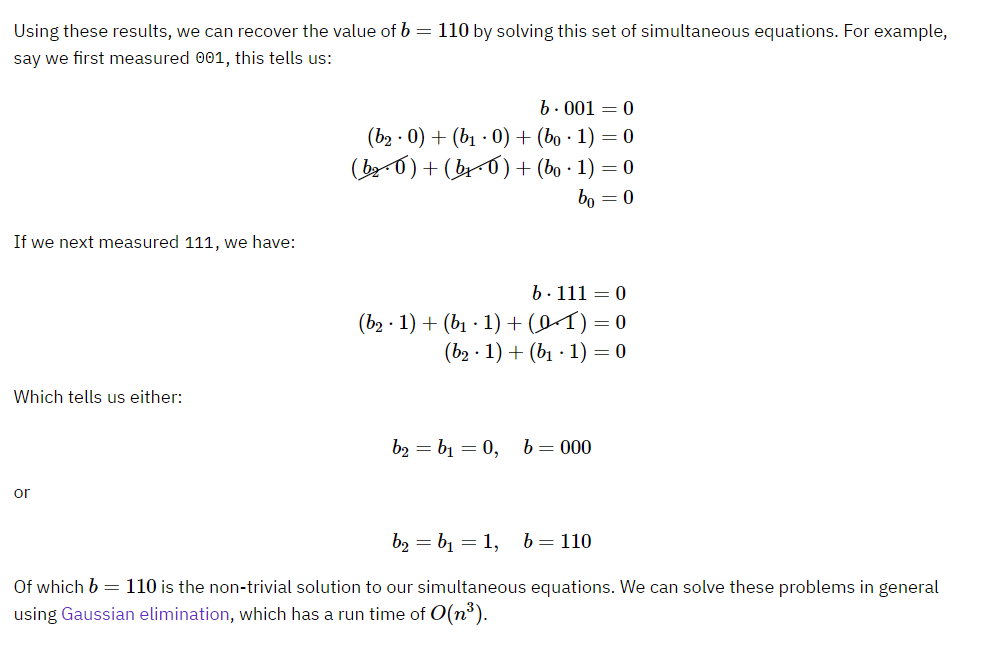

# 5. Real Device

We are using 4 qubits because most of the IBM Quantum devices have 5 qubits only

In [8]:
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))
simon_circuit_2.barrier()

# Query oracle
simon_circuit_2 += simon_oracle(b)
simon_circuit_2.barrier()

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()

┌───┐ ░                      ░ ┌───┐┌─┐   
q_0: ┤ H ├─░───■─────────■────■───░─┤ H ├┤M├───
     ├───┤ ░   │         │    │   ░ ├───┤└╥┘┌─┐
q_1: ┤ H ├─░───┼────■────┼────┼───░─┤ H ├─╫─┤M├
     └───┘ ░ ┌─┴─┐  │  ┌─┴─┐  │   ░ └───┘ ║ └╥┘
q_2: ──────░─┤ X ├──┼──┤ X ├──┼───░───────╫──╫─
           ░ └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║ 
q_3: ──────░──────┤ X ├─────┤ X ├─░───────╫──╫─
           ░      └───┘     └───┘ ░       ║  ║ 
c: 2/═════════════════════════════════════╩══╩═
                                          0  1

The outputs are different, but the input collisions are the same, i.e. both have the property that f(x) = f(x⊕11)

In [9]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)

least busy backend:  ibmq_lima


<ipython-input-9-8416f06a3ca6>:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(qobj)


Job Status: job has successfully run


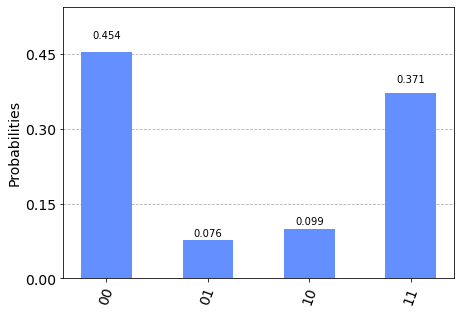

In [10]:
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

# 6. Verify Result(Real Device)

In [11]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

print('b = ' + b)
for z in device_counts:
    print( '{}.{} = {} (mod 2) ({:.1f}%)'.format(b, z, bdotz(b,z), device_counts[z]*100/shots))

b = 11
11.00 = 0 (mod 2) (45.4%)
11.01 = 1 (mod 2) (7.6%)
11.10 = 1 (mod 2) (9.9%)
11.11 = 0 (mod 2) (37.1%)


 As we can see, the most significant results are those for which **b⋅z=0(mod 2)**. The other results are erroneous, but have a lower probability of occurring. Assuming we are unlikely to measure the erroneous results, we can then use a classical computer to recover the value of **b** by solving the linear system of equations. For this **n=2** case, **b=11**.